In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert MNIST to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
device = torch.device("cuda")

In [4]:
# training dataset called "train_data" using the MNIST dataset from the 'mnist_data' directory
train_data = torchvision.datasets.MNIST('mnist_data',train=True , download=True , transform =transform)
# validation dataset called "val_data" using the MNIST dataset from the 'mnist_data' directory.
val_data = torchvision.datasets.MNIST('mnist_data',train=False , download=True , transform =transform)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=64)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=64)

100%|██████████| 9912422/9912422 [00:00<00:00, 172243880.92it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111440380.70it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48268365.41it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4579454.03it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
len(val_dl)

157

In [17]:
# Load a pre-trained ResNet18 model
model = models.mobilenet_v2(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
model.classifier[1] = nn.Linear(model.last_channel, 10)
model = model.to(device)

In [19]:

# Set the model to training mode
model.train()



MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [27]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [21]:
# Define a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

In [10]:
model = model.to(device)

In [22]:
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [23]:
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=False)

In [24]:
true_labels = []
predicted_labels = []


In [25]:
model = model.to(device)
num_epochs = 5
best_accuracy = 0.0

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    true_labels = []  # Initialize true_labels for this epoch
    predicted_labels = []  # Initialize predicted_labels for this epoch

    # Use tqdm to display a progress bar
    for images, labels in tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()

        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Now, you can safely pass the input through the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Convert tensors to numpy arrays and append to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.2f}%')

# After all epochs are completed
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Epoch 1/5: 100%|██████████| 157/157 [00:54<00:00,  2.89it/s]


Loss: 2.2951, Accuracy: 14.68%


Epoch 2/5: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]


Loss: 2.2444, Accuracy: 20.84%


Epoch 3/5: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]


Loss: 2.1598, Accuracy: 21.87%


Epoch 4/5: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]


Loss: 2.0507, Accuracy: 24.53%


Epoch 5/5: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]

Loss: 1.9617, Accuracy: 28.25%
Confusion Matrix:
[[ 179    8  250  272   24   30   28   57   89   43]
 [   0 1125    2    2    0    0    1    4    0    1]
 [ 133   14  312  346   20   44   31   52   48   32]
 [ 127    5  291  401   15   61   12   27   44   27]
 [  50  116   87   82  117   21   38  339   33   99]
 [  97   19  218  318   18   59   15   38   78   32]
 [  75  101  181  169   49   18   58  165   67   75]
 [  25  262   64   78   86   17   32  361   19   84]
 [ 101   44  208  268   36   42   30   79   84   82]
 [  54  110  120  161   65   43   33  247   47  129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.18      0.20       980
           1       0.62      0.99      0.77      1135
           2       0.18      0.30      0.23      1032
           3       0.19      0.40      0.26      1010
           4       0.27      0.12      0.17       982
           5       0.18      0.07      0.10       892
           6      

In [28]:
model = model.to(device)
num_epochs = 5
best_accuracy = 0.0

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    true_labels = []  # Initialize true_labels for this epoch
    predicted_labels = []  # Initialize predicted_labels for this epoch

    # Use tqdm to display a progress bar
    for images, labels in tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()

        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Now, you can safely pass the input through the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Convert tensors to numpy arrays and append to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.2f}%')

# After all epochs are completed
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Epoch 1/5: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]


Loss: 1.5857, Accuracy: 45.75%


Epoch 2/5: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]


Loss: 0.6831, Accuracy: 83.10%


Epoch 3/5: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]


Loss: 0.2419, Accuracy: 94.83%


Epoch 4/5: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]


Loss: 0.1316, Accuracy: 97.25%


Epoch 5/5: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s]

Loss: 0.0777, Accuracy: 98.50%
Confusion Matrix:
[[ 969    0    5    0    0    0    3    0    2    1]
 [   0 1121    5    1    2    0    2    4    0    0]
 [   3    1 1022    0    0    0    2    2    1    1]
 [   0    0    2  998    0    4    0    4    1    1]
 [   5    0    0    0  969    0    2    0    0    6]
 [   0    0    2    8    0  874    1    3    2    2]
 [   3    2    0    0    2    2  946    0    3    0]
 [   0    2    5    1    4    0    0 1016    0    0]
 [   0    0    0    3    0    2    2    0  959    8]
 [   3    1    0    4   10    1    0    5    9  976]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6      

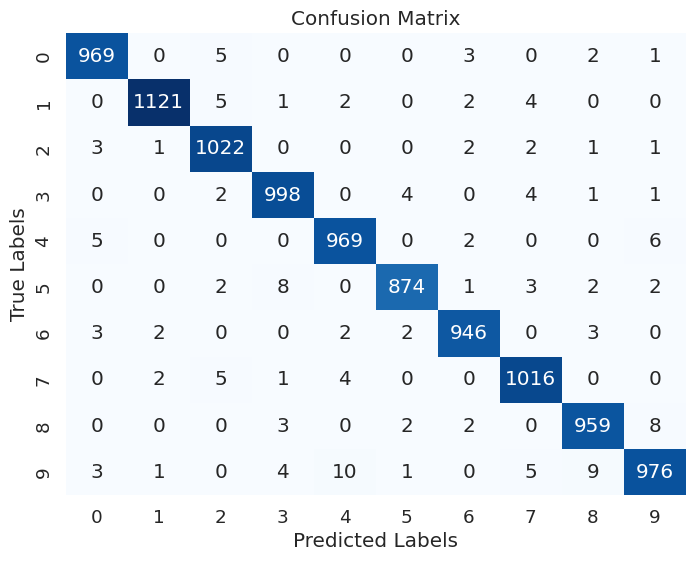

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()